In [10]:
from google.colab import files
files.upload()  # Choose kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manukondarajdhanush","key":"6aceaf9e525e75efd5509636cc1ccaa8"}'}

In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
!kaggle datasets download -d mohitsingh1804/plantvillage


Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
 99% 811M/818M [00:11<00:00, 140MB/s]
100% 818M/818M [00:11<00:00, 76.7MB/s]


In [15]:
!unzip -q plantvillage.zip -d PlantVillage


In [16]:
import os
print(os.listdir('PlantVillage'))


['PlantVillage']


In [17]:
import os
print(os.listdir("PlantVillage/PlantVillage"))


['val', 'train']


In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, cohen_kappa_score)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
TRAIN_DIR = "PlantVillage/PlantVillage/train"
VAL_DIR   = "PlantVillage/PlantVillage/val"

IMG_SIZE = (128,128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

class_names = list(train_data.class_indices.keys())
print("Classes:", class_names)

Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'T

In [ ]:
def extract_features(base_model, train_data, val_data):
    """Extract deep features using pretrained CNN backbone"""
    feature_extractor = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    # Extract features
    X_train = feature_extractor.predict(train_data, verbose=1)
    X_val   = feature_extractor.predict(val_data, verbose=1)
    y_train = train_data.classes
    y_val   = val_data.classes

    return X_train, X_val, y_train, y_val


In [ ]:
def evaluate_ml_models(X_train, X_val, y_train, y_val, backbone_name):
    results = []
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "KNN": KNeighborsClassifier(),
        "DecisionTree": DecisionTreeClassifier(),
        "RandomForest": RandomForestClassifier(n_estimators=100)
    }

    for name, clf in classifiers.items():
        start = time.time()
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        end = time.time()

        metrics = {
            "Backbone": backbone_name,
            "Classifier": name,
            "Accuracy": accuracy_score(y_val, preds),
            "Precision": precision_score(y_val, preds, average="weighted", zero_division=0),
            "Recall": recall_score(y_val, preds, average="weighted", zero_division=0),
            "F1": f1_score(y_val, preds, average="weighted", zero_division=0),
            "Kappa": cohen_kappa_score(y_val, preds),
            "Time (s)": round(end-start,2)
        }
        results.append(metrics)
        print(f"{backbone_name} + {name} => Acc: {metrics['Accuracy']:.4f}")
    return results


In [ ]:
# Define pretrained CNNs
base_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3))

all_results = []

# ResNet50
X_train_res, X_val_res, y_train_res, y_val_res = extract_features(base_resnet, train_data, val_data)
all_results += evaluate_ml_models(X_train_res, X_val_res, y_train_res, y_val_res, "ResNet50")

# MobileNetV2
X_train_mob, X_val_mob, y_train_mob, y_val_mob = extract_features(base_mobilenet, train_data, val_data)
all_results += evaluate_ml_models(X_train_mob, X_val_mob, y_train_mob, y_val_mob, "MobileNetV2")

# VGG16
X_train_vgg, X_val_vgg, y_train_vgg, y_val_vgg = extract_features(base_vgg, train_data, val_data)
all_results += evaluate_ml_models(X_train_vgg, X_val_vgg, y_train_vgg, y_val_vgg, "VGG16")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2284s 2s/step
340/340 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ResNet50 + LogisticRegression => Acc: 0.5418
ResNet50 + KNN => Acc: 0.5130
ResNet50 + DecisionTree => Acc: 0.3404
ResNet50 + RandomForest => Acc: 0.5500
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 529s 388ms/step
340/340 ━━━━━━━━━━━━━━━━━━━━ 135s 398ms/step
MobileNetV2 + LogisticRegression => Acc: 0.9483
MobileNetV2 + KNN => Acc: 0.9053
MobileNetV2 + DecisionTree => Acc: 0.5818
MobileNetV2 + RandomForest => Acc: 0.8532
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 7307s 5s/step
340/340 ━━━━━━━━━━━━━━━━━━━━ 1830s 5s/step
VGG16 + LogisticRegression => Acc: 0.9154
VGG16 + KNN => Acc: 0.8600
VGG16 + DecisionTree => Acc: 0.5581
VGG16 + RandomForest => Acc: 0.8155


In [ ]:
# Store results in DataFrame
df_results = pd.DataFrame(all_results)
print("\nFinal Results:")
print(df_results)

# Save results to CSV
df_results.to_csv("deep_features_results.csv", index=False)



Final Results:
       Backbone          Classifier  Accuracy  Precision    Recall        F1  \
0      ResNet50  LogisticRegression  0.541755   0.518869  0.541755  0.508139   
1      ResNet50                 KNN  0.513028   0.514117  0.513028  0.497258   
2      ResNet50        DecisionTree  0.340392   0.342272  0.340392  0.340965   
3      ResNet50        RandomForest  0.550041   0.562335  0.550041  0.508818   
4   MobileNetV2  LogisticRegression  0.948255   0.948322  0.948255  0.948193   
5   MobileNetV2                 KNN  0.905349   0.908134  0.905349  0.903301   
6   MobileNetV2        DecisionTree  0.581806   0.582900  0.581806  0.582001   
7   MobileNetV2        RandomForest  0.853236   0.852431  0.853236  0.841776   
8         VGG16  LogisticRegression  0.915385   0.914505  0.915385  0.914352   
9         VGG16                 KNN  0.859958   0.863080  0.859958  0.856363   
10        VGG16        DecisionTree  0.558144   0.562553  0.558144  0.560008   
11        VGG16        R

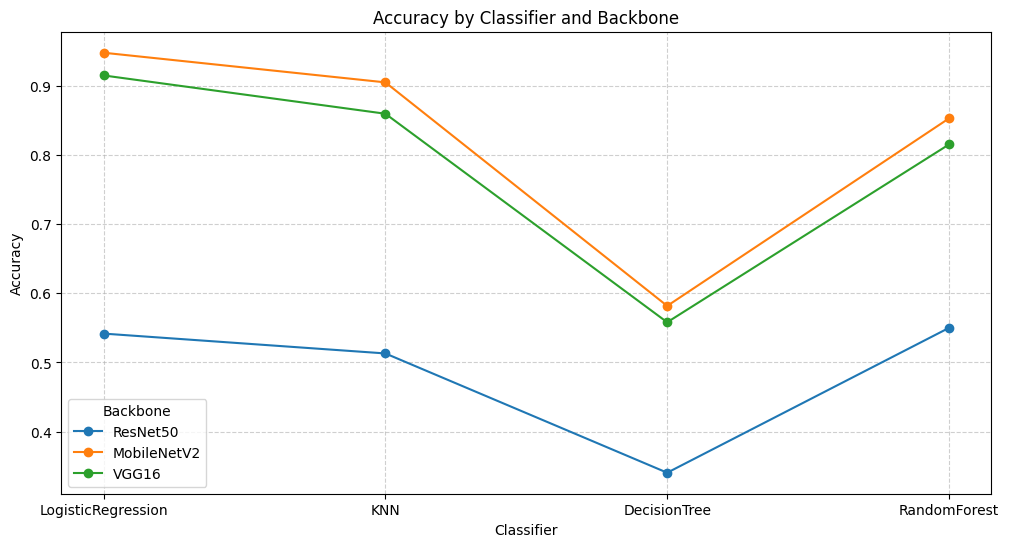

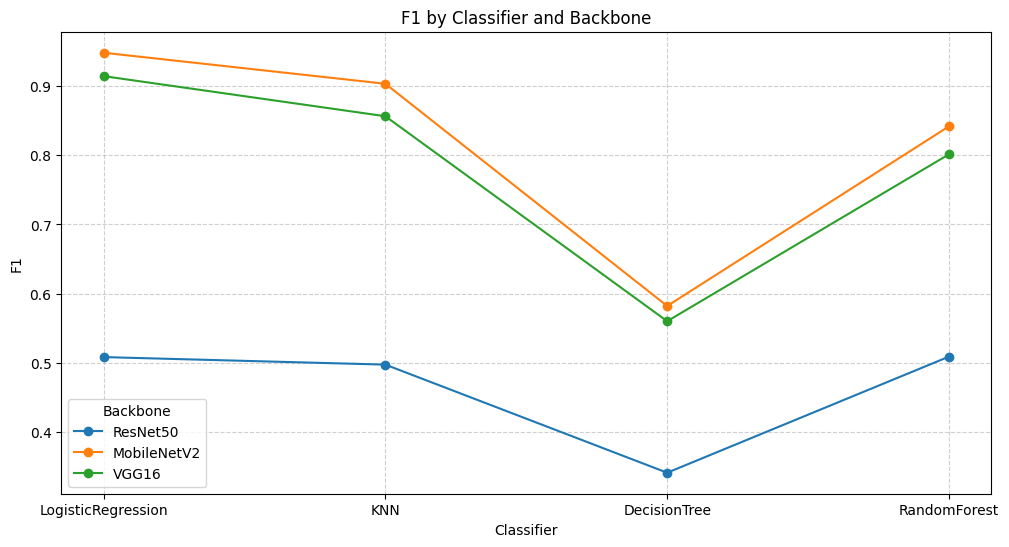

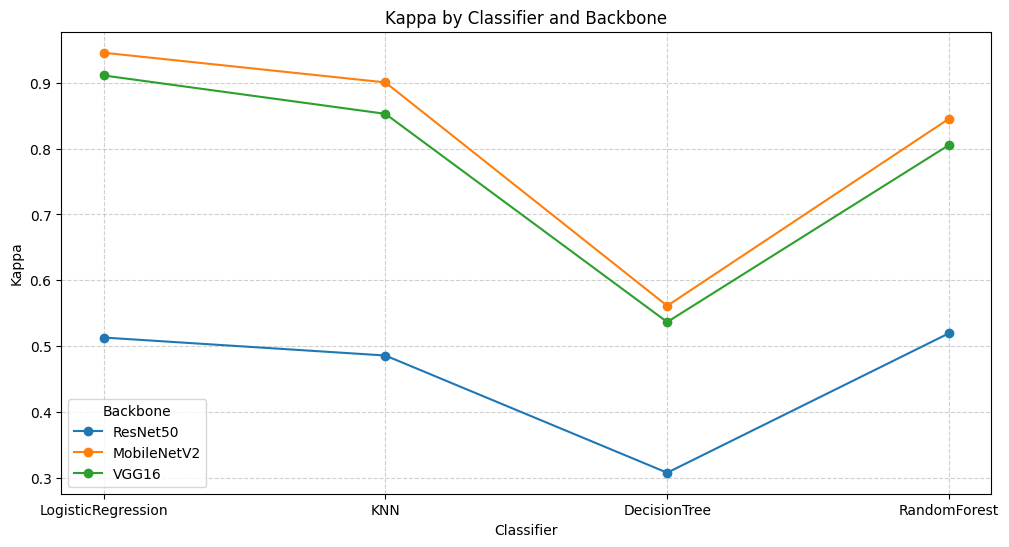

In [ ]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "F1", "Kappa"]

for metric in metrics:
    plt.figure(figsize=(12,6))
    for backbone in df_results["Backbone"].unique():
        subset = df_results[df_results["Backbone"] == backbone]
        plt.plot(subset["Classifier"], subset[metric], marker="o", label=backbone)
    plt.title(f"{metric} by Classifier and Backbone")
    plt.xlabel("Classifier")
    plt.ylabel(metric)
    plt.legend(title="Backbone")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


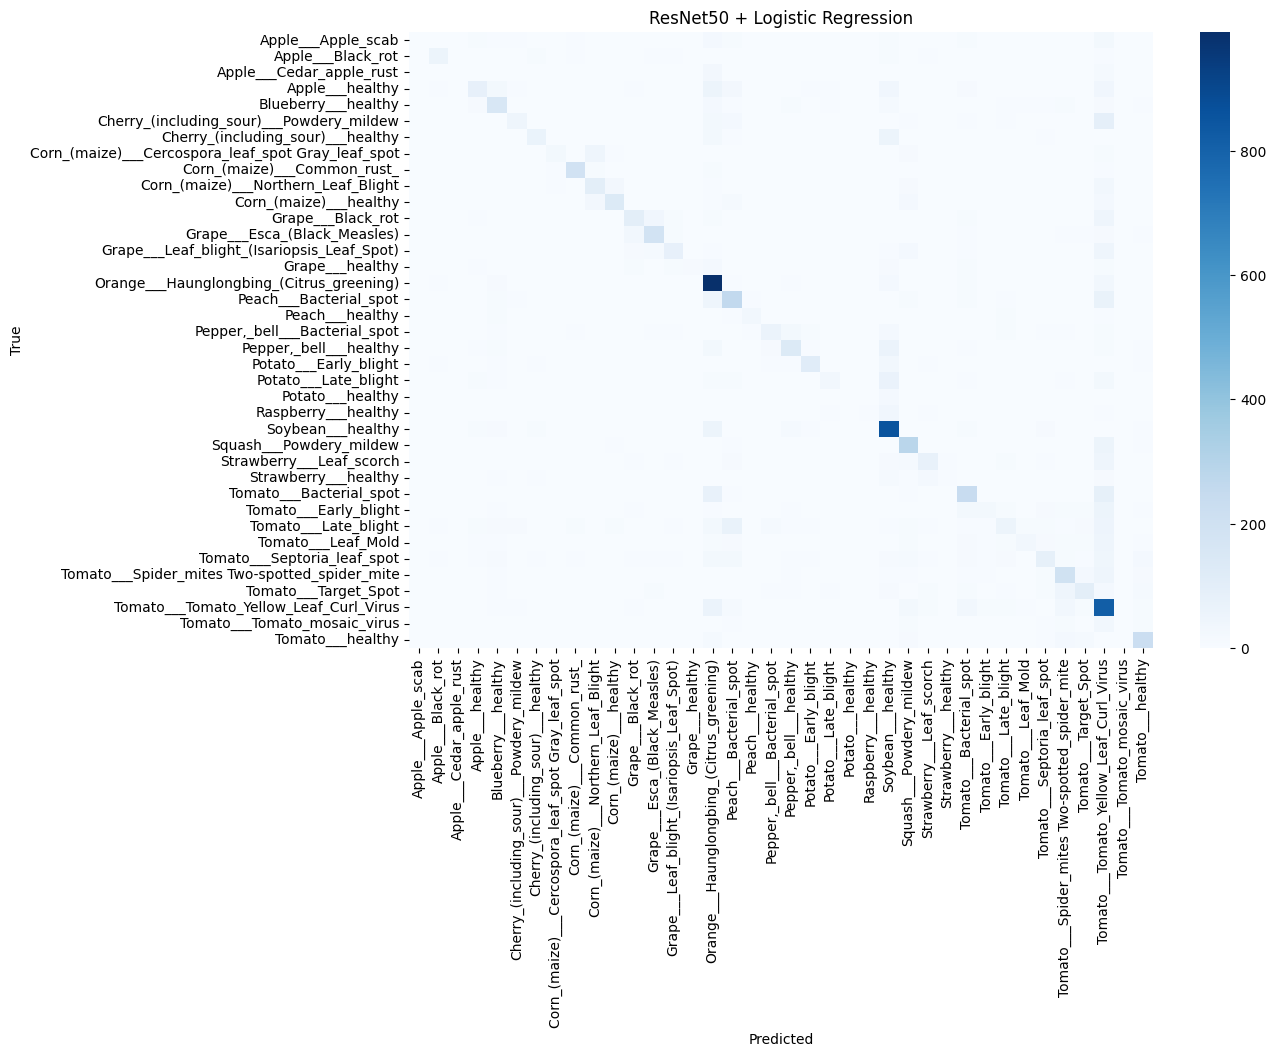

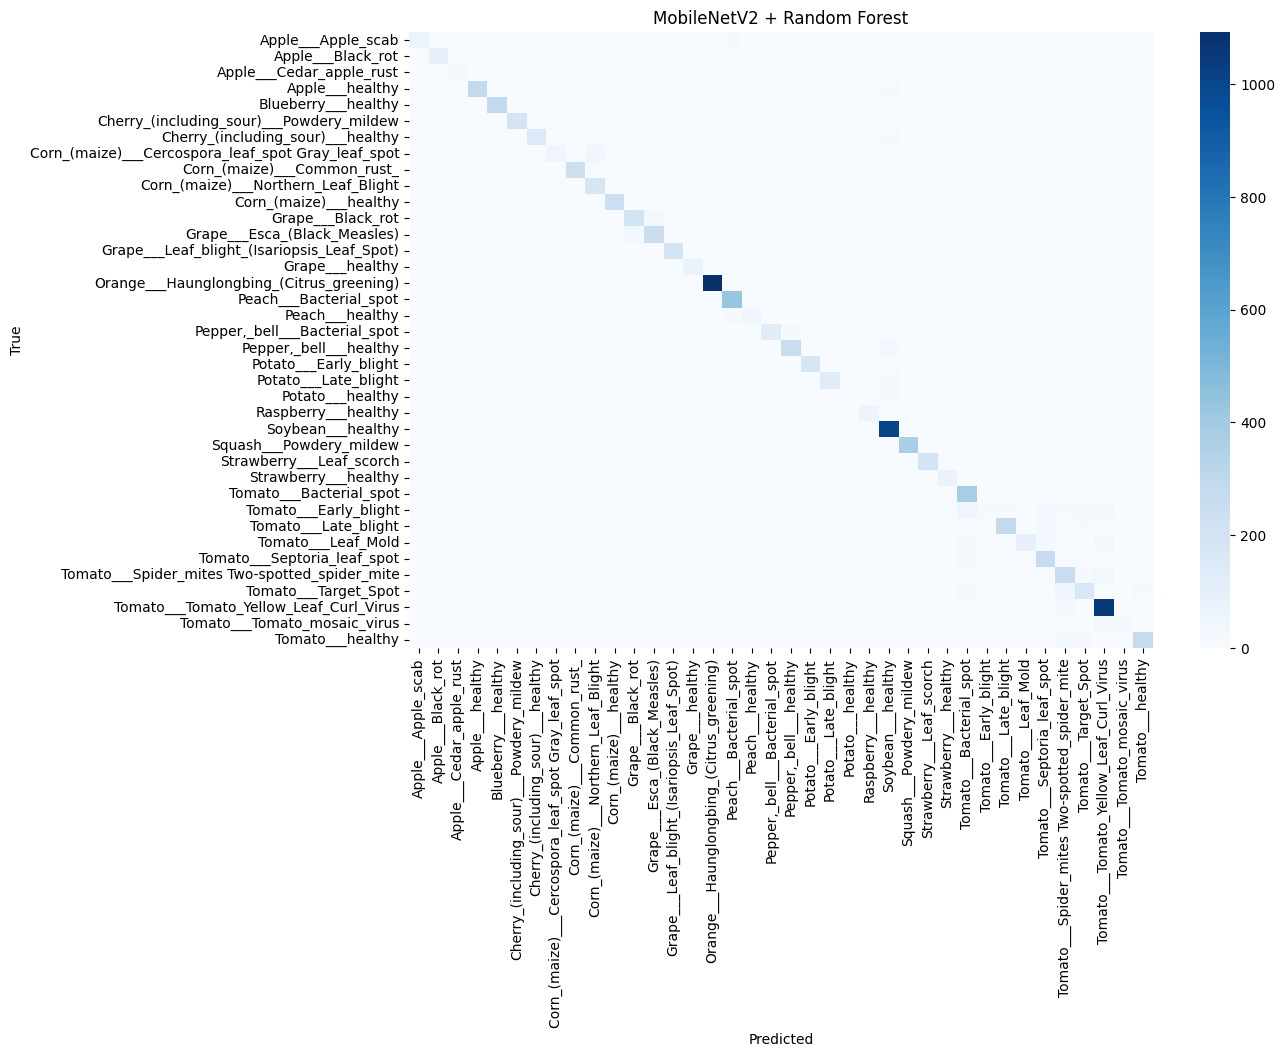

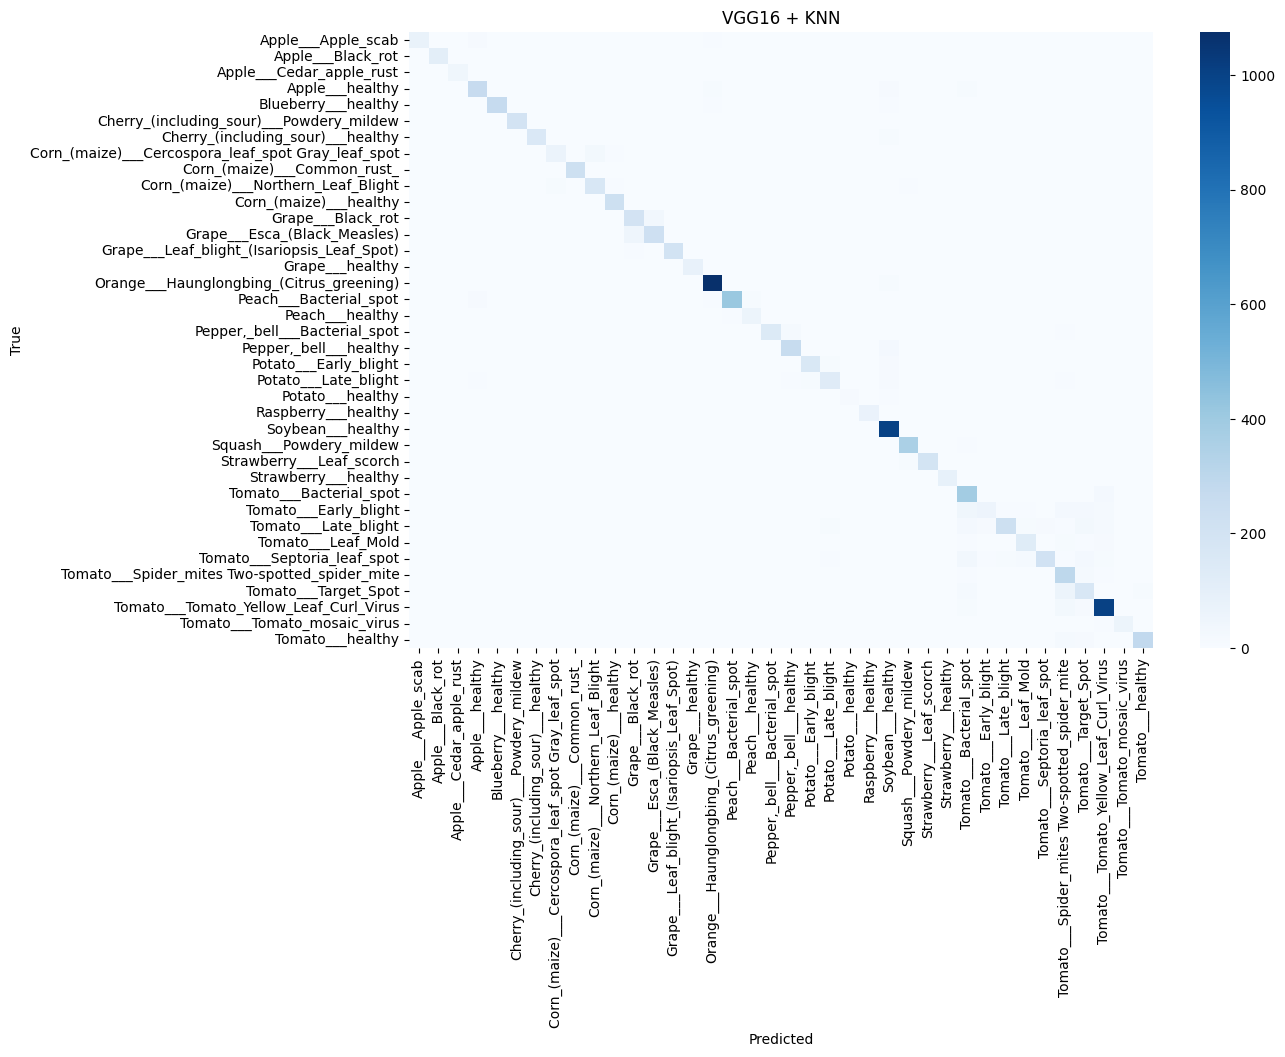

In [ ]:
import seaborn as sns

def plot_confusion_matrix(clf, X_val, y_val, class_names, title):
    preds = clf.predict(X_val)
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Example: ResNet50 + Logistic Regression
log_reg = LogisticRegression(max_iter=1000).fit(X_train_res, y_train_res)
plot_confusion_matrix(log_reg, X_val_res, y_val_res, class_names, "ResNet50 + Logistic Regression")

# Example: MobileNetV2 + Random Forest
rf = RandomForestClassifier(n_estimators=100).fit(X_train_mob, y_train_mob)
plot_confusion_matrix(rf, X_val_mob, y_val_mob, class_names, "MobileNetV2 + Random Forest")

# Example: VGG16 + KNN
knn = KNeighborsClassifier().fit(X_train_vgg, y_train_vgg)
plot_confusion_matrix(knn, X_val_vgg, y_val_vgg, class_names, "VGG16 + KNN")


In [ ]:
np.save("X_train_mobilenet.npy", X_train_mob)
np.save("X_val_mobilenet.npy", X_val_mob)
np.save("y_train_mobilenet.npy", y_train_mob)
np.save("y_val_mobilenet.npy", y_val_mob)

# Save VGG features
np.save("X_train_vgg.npy", X_train_vgg)
np.save("X_val_vgg.npy", X_val_vgg)
np.save("y_train_vgg.npy", y_train_vgg)
np.save("y_val_vgg.npy", y_val_vgg)

In [ ]:
files.download("X_train_mobilenet.npy")
files.download("X_val_mobilenet.npy")
files.download("y_train_mobilenet.npy")
files.download("y_val_mobilenet.npy")

# Download VGG files
files.download("X_train_vgg.npy")
files.download("X_val_vgg.npy")
files.download("y_train_vgg.npy")
files.download("y_val_vgg.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import files

# Upload the saved files from your PC
uploaded = files.upload()


Saving y_val_vgg.npy to y_val_vgg.npy
Saving y_val_resnet.npy to y_val_resnet.npy
Saving y_val_mobilenet.npy to y_val_mobilenet.npy
Saving y_train_vgg.npy to y_train_vgg.npy
Saving y_train_resnet.npy to y_train_resnet.npy
Saving y_train_mobilenet.npy to y_train_mobilenet.npy
Saving X_val_vgg.npy to X_val_vgg.npy
Saving X_val_resnet.npy to X_val_resnet.npy
Saving X_val_mobilenet.npy to X_val_mobilenet.npy
Saving X_train_vgg.npy to X_train_vgg.npy
Saving X_train_resnet.npy to X_train_resnet.npy
Saving X_train_mobilenet.npy to X_train_mobilenet.npy


In [6]:
import numpy as np

# Example for MobileNet
X_train_mobile = np.load("X_train_mobilenet.npy")
X_val_mobile   = np.load("X_val_mobilenet.npy")
y_train_mobile = np.load("y_train_mobilenet.npy")
y_val_mobile   = np.load("y_val_mobilenet.npy")

# Example for VGG
X_train_vg = np.load("X_train_vgg.npy")
X_val_vg   = np.load("X_val_vgg.npy")
y_train_vg = np.load("y_train_vgg.npy")
y_val_vg   = np.load("y_val_vgg.npy")


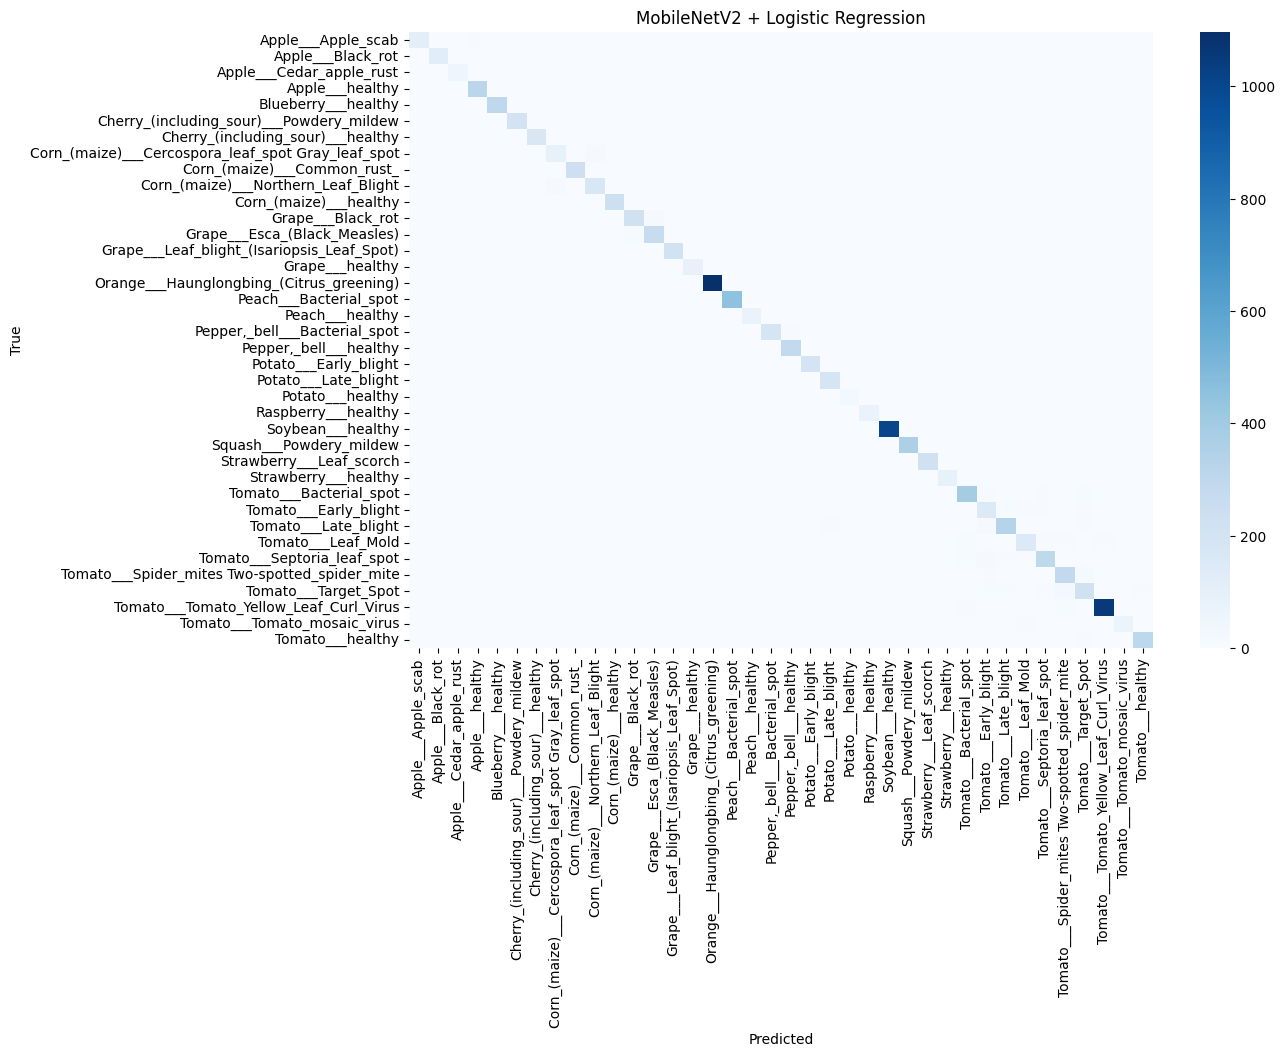

In [21]:
import seaborn as sns

def plot_confusion_matrix(clf, X_val, y_val, class_names, title):
    preds = clf.predict(X_val)
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Example: MobileNetV2 + Logistic Regression
log_reg = LogisticRegression(max_iter=1000).fit(X_train_mobile, y_train_mobile)
plot_confusion_matrix(log_reg, X_val_mobile, y_val_mobile, class_names, "MobileNetV2 + Logistic Regression")




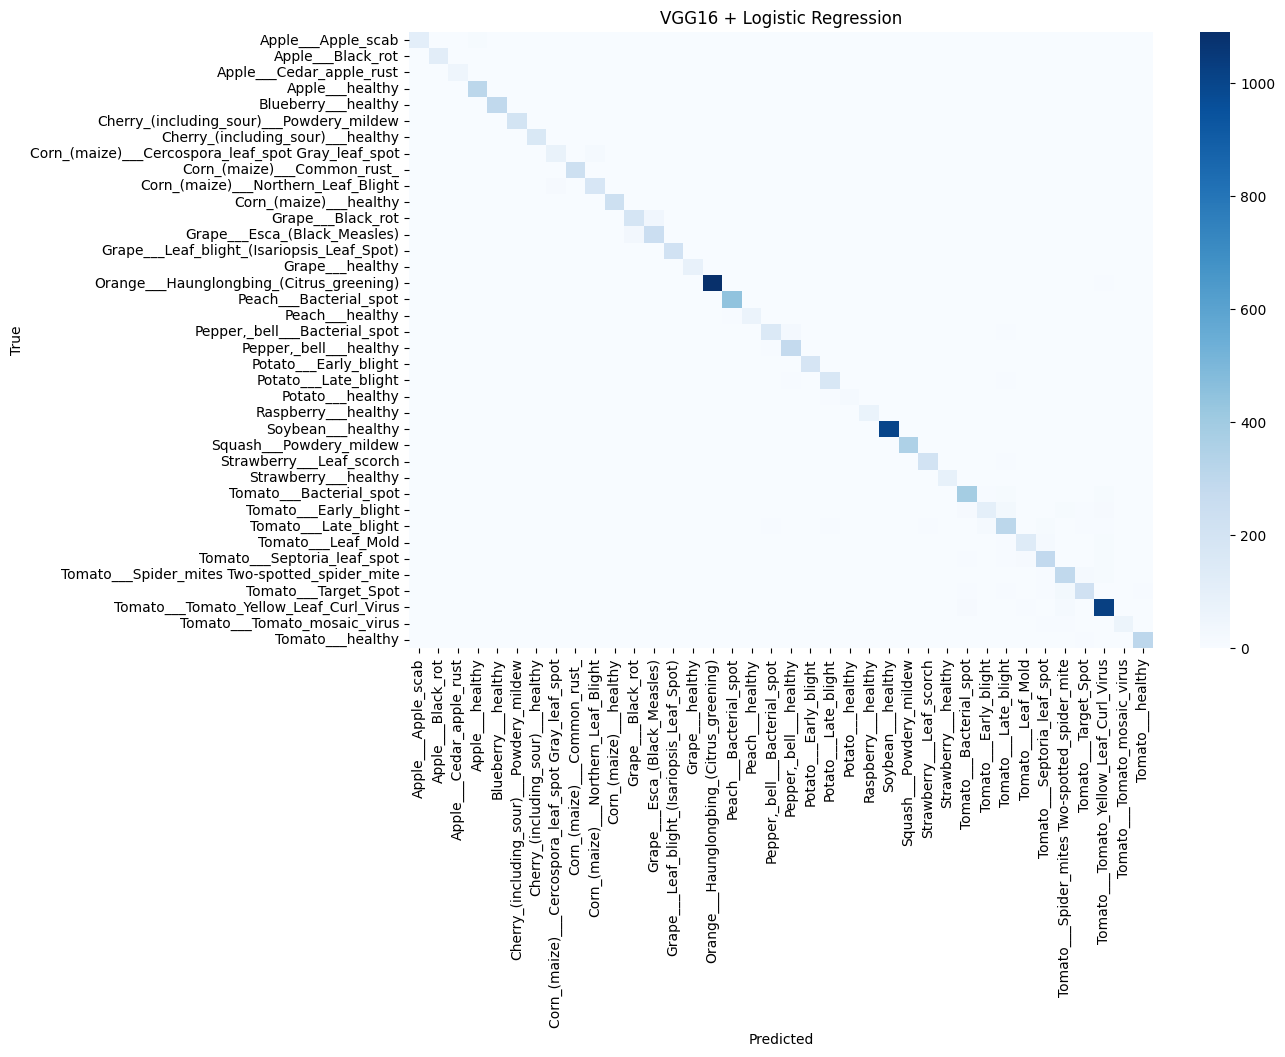

In [11]:
import seaborn as sns

def plot_confusion_matrix(clf, X_val, y_val, class_names, title):
    preds = clf.predict(X_val)
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Example: MobileNetV2 + Logistic Regression
log_reg = LogisticRegression(max_iter=1000).fit(X_train_vg, y_train_vg)
plot_confusion_matrix(log_reg, X_val_vg, y_val_vg, class_names, "VGG16 + Logistic Regression")


